In [1]:
import numpy as np
import copy
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from collections import defaultdict

plt.rcParams['figure.figsize'] = (40.0, 20.0)

In [14]:
file_location = "../data/Raman_Mouse/raw_npy/"
filenames = np.load(f"{file_location}FileNames.npy")

data = []
for f in filenames:
    data.append(np.load(f"{file_location}{f}"))
data = np.array(data)

At least 96 pixels have an anomaly.

In [10]:
def find_cosmic_ray_noise(img):
    """
    find cosmic ray noise based on the wavelengths within one pixel (a large difference of intensities)
    """
    smooth = gaussian_filter(img, sigma=(0,0,1), order=0, mode='nearest')
    diff = img-smooth
    grad = gaussian_filter(diff, sigma=(0,0,0.5), order=1, mode='nearest')

    # find the elbow in the data
    data = np.sort(np.abs(grad.flatten()))
    sec = gaussian_filter(data[1:] - data[:-1], sigma=3)
    m_sec, s_std = np.mean(sec), np.std(sec)
    threshold = data[np.max(np.where(sec < m_sec + 0.5*s_std))]    
    
    # make a dict where per pixel the problem area's are in.
    tmp = defaultdict(list)
    for x,y,z in zip(*np.where(grad > threshold)):
        tmp[(x,y)].append(z)
        
    return tmp

def find_cosmic_ray_noise_neighbourhood(img):
    """
    find cosmic ray noise based also on the neighbourhood (a large difference of intensities)
    This returns false positives if in the neighbourhood there is a large spike but not in the pixel it self.
    """
    smooth = gaussian_filter(img, sigma=(1,1,1), order=0, mode='nearest')
    diff = img-smooth
    grad = gaussian_filter(diff, sigma=(0,0,0.5), order=1, mode='nearest')

    # find the elbow in the data
    data = np.sort(np.abs(grad.flatten()))
    sec = gaussian_filter(data[1:] - data[:-1], sigma=3)
    m_sec, s_std = np.mean(sec), np.std(sec)
    threshold = data[np.max(np.where(sec < m_sec + 0.5*s_std))]    
    
    # make a dict where per pixel the problem area's are in.
    tmp = defaultdict(list)
    for x,y,z in zip(*np.where(grad > threshold)):
        tmp[(x,y)].append(z)
        
    return tmp

def find_region(lst):
    lst = sorted(lst)
    start = []
    stop = []
    index = lst[0]
    start.append(index)
    for i in lst[1:]:
        if i-index < 5:
            index = i
        else:
            stop.append(index)
            index = i
            start.append(index)
    stop.append(index)
    return list(zip(start, stop))

def correcting_4_cosmic_ray_noies(img, cosmic_ray_noise):
    img2 = copy.copy(img)
    
    for (x,y), lst in cosmic_ray_noise.items():
        for Range in find_region(lst):
            size = Range[1]-Range[0]
            padding = int(4 + (size)/2)
            X = np.arange(max(0,Range[0]-padding), min(1000,Range[1]+padding+1), dtype=int)
            img2[x,y,X[0]:X[-1]+1] = np.interp(X, [X[0], X[-1]], 
                                                    [img[x,y,X[0]],
                                                     img[x,y,X[-1]]])   
    return img2
    

Liver_map_150z25_60s_#12.npy
99


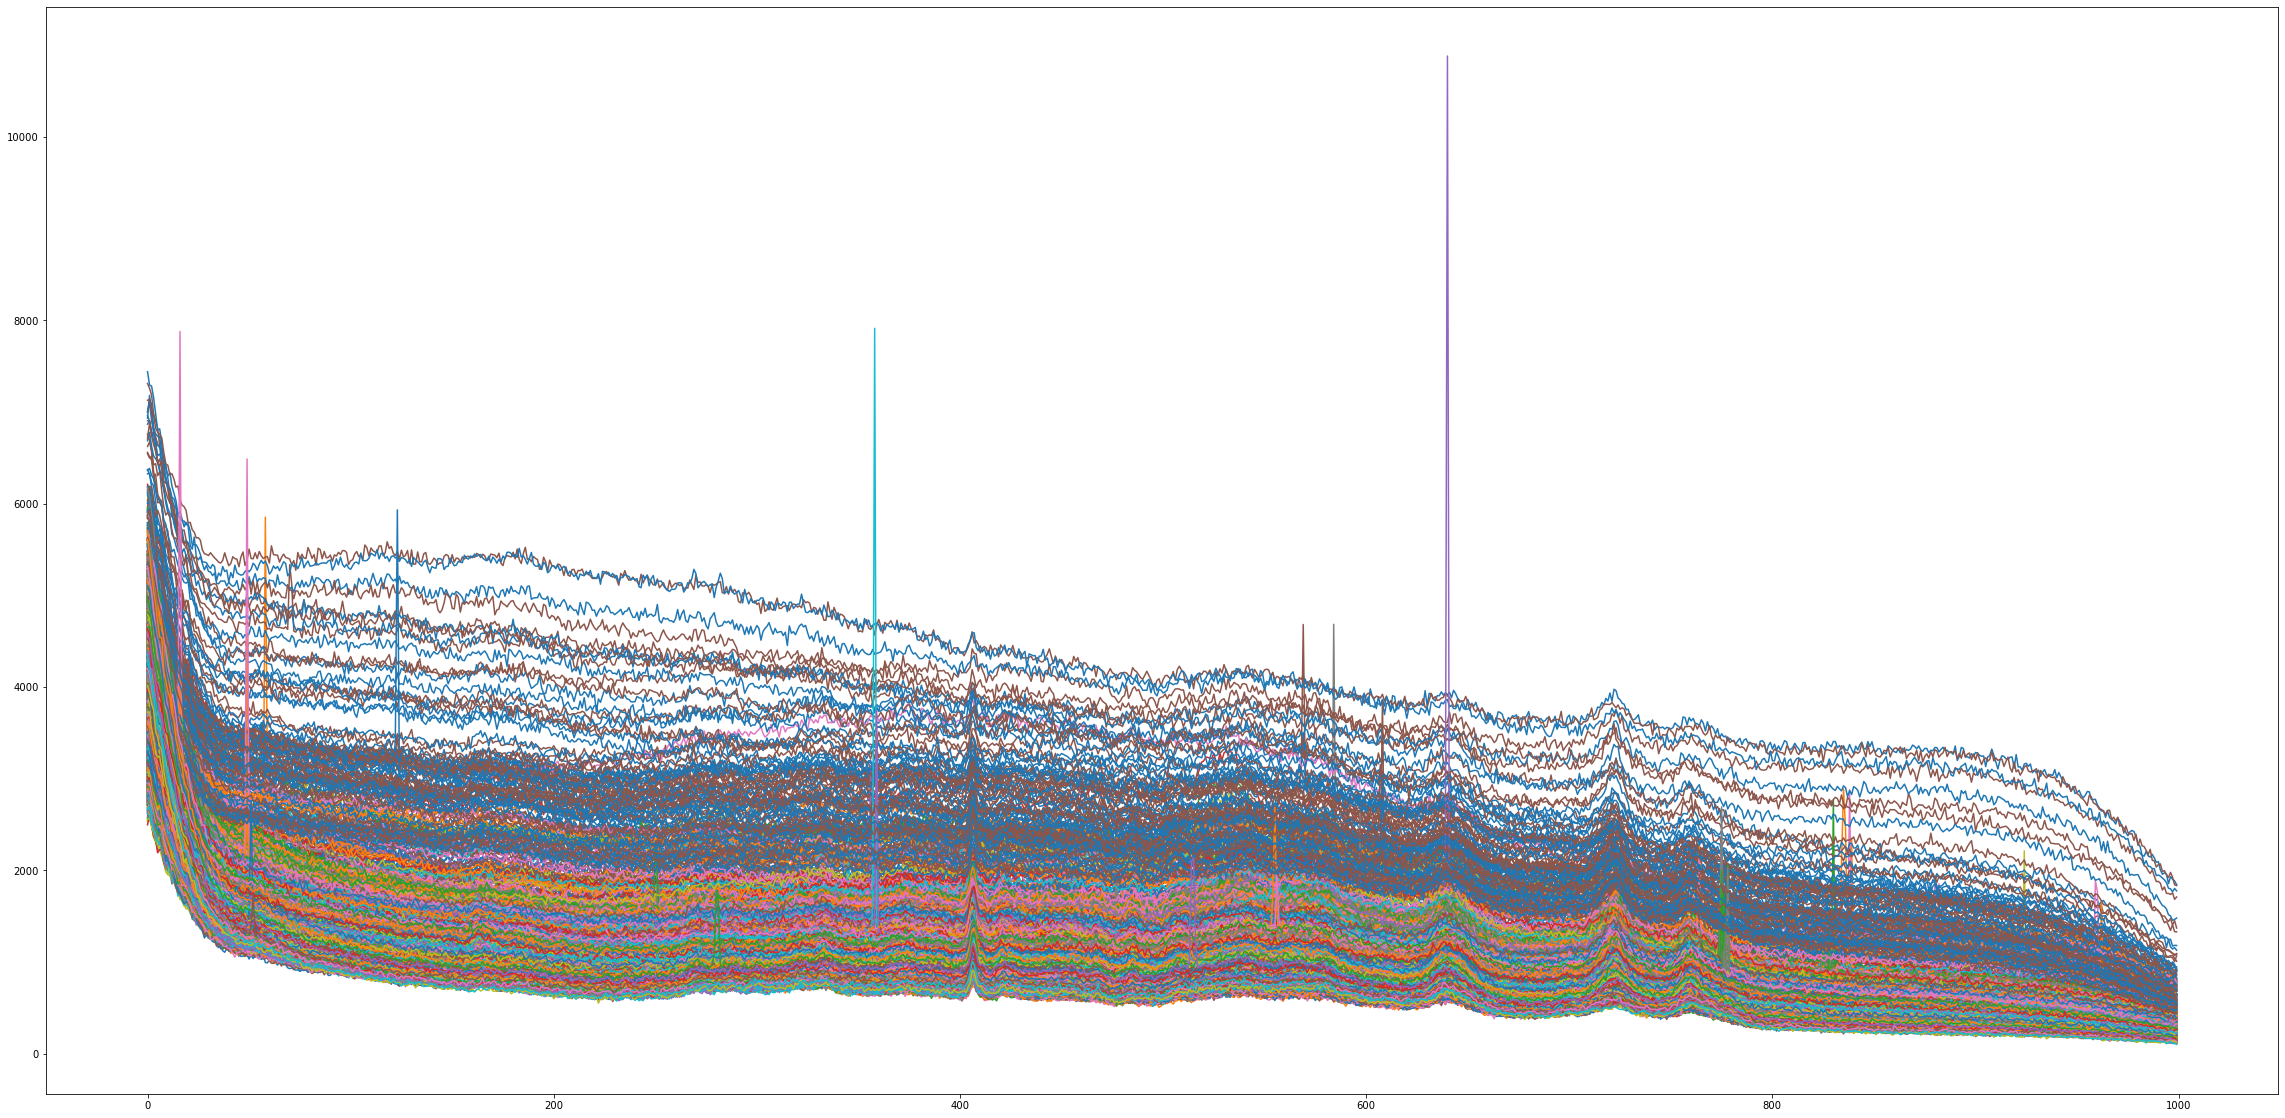

Muscle_map_150z25_60s_#34.npy
125


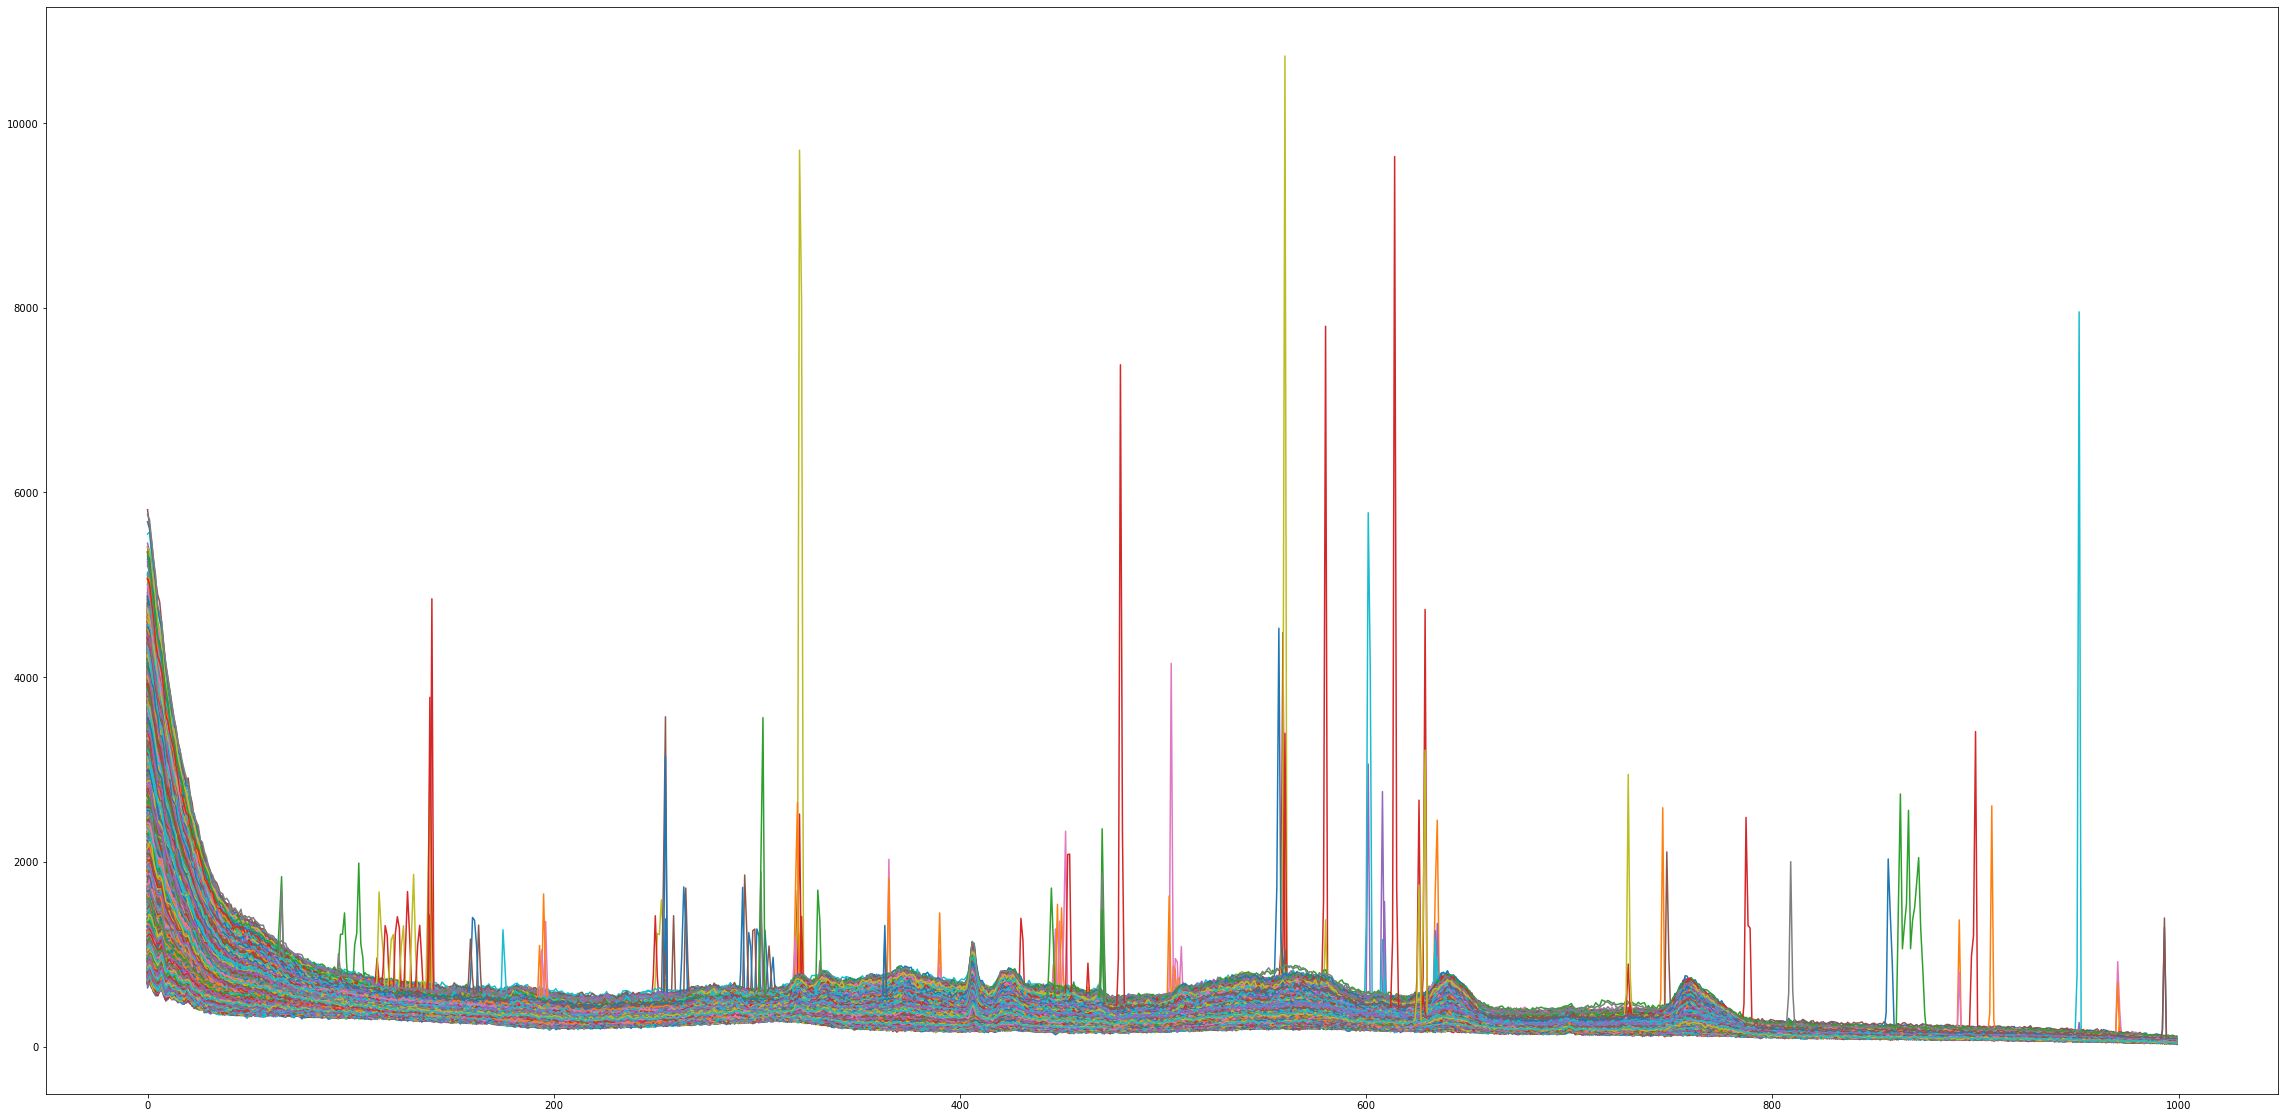

Kidney_map_150z25_60s_#45.npy
141


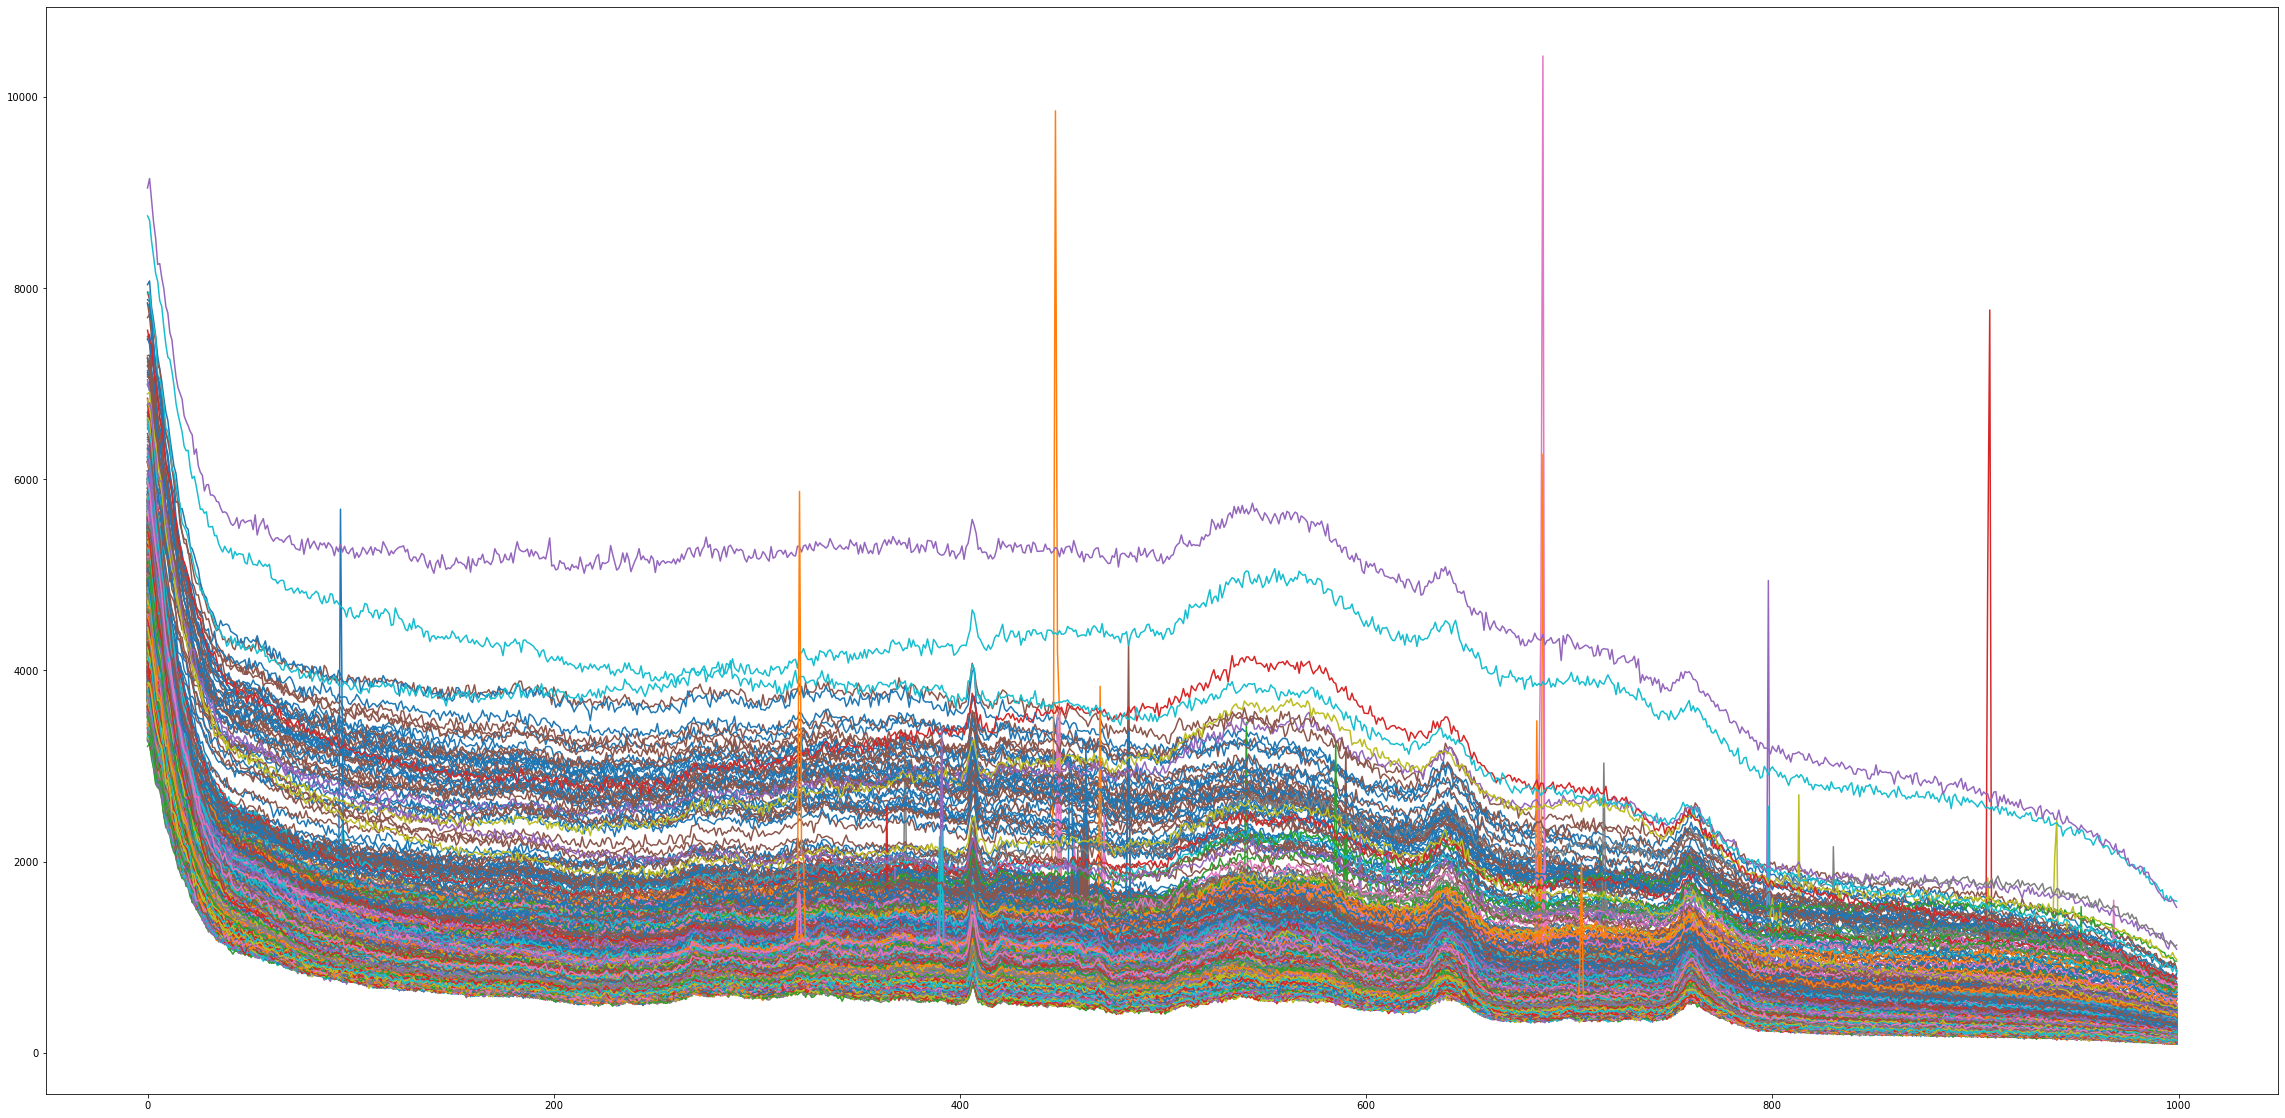

Kidney_map_150z25_60s_#43.npy
168


KeyboardInterrupt: 

In [20]:
file_location2 = "../data/Raman_Mouse/cosmic_ray_removed/"

for i, img in enumerate(data):
    print(filenames[i])

    tmp = find_cosmic_ray_noise(img)
    tmp2 = find_cosmic_ray_noise_neighbourhood(img)
    
    # if both functions find cosmic ray noise then it is classified as noise.
    cosmic_ray_noise = {pixel:list(set(z).union(set(tmp2[pixel]))) for pixel, z in tmp.items() if pixel in tmp2}
    img2 = correcting_4_cosmic_ray_noies(img, cosmic_ray_noise)

    
    # plot problem points
    print(len(cosmic_ray_noise))
#     for (x,y), lst in cosmic_ray_noise.items():
#         for z in lst:
#             plt.plot([z,z],[-2000,5000], alpha=0.1, color='k')
#         plt.plot(img2[x,y])
#         plt.plot(img[x,y], alpha=0.4)
#         plt.show()

    # plot all points
#     for x in img2:
#         for y in x:
#             plt.plot(y)
#     plt.show()

#     np.save(f'{file_location2}{filenames[i].split("/")[-1].split(".")[0]}', img2) 


In [16]:
for f in filenames:
    wavelength = np.load(f"{file_location}{f.split('.')[0]}_wavelength.npy")
    np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_wavelength.npy', wavelength) 

np.save(f'{file_location2}FileNames', filenames)  

